# Download multiple meteoscreening variables

**notebook version**: `3` (4 Jul 2024)  
**new in this version**: added check if downloaded data is indeed in 30MIN time resolution

- This notebook can be used to download data from the database `InfluxDB`
- Data are stored to a `.csv` file in this folder

</br>

# Settings

## Data settings

In [1]:
DIRCONF = r'F:\Sync\luhk_work\20 - CODING\22 - POET\configs'
# DIRCONF = r'P:\Flux\RDS_calculations\_scripts\_configs\configs'  # Folder with configuration files: needed e.g. for connection to database
TIMEZONE_OFFSET_TO_UTC_HOURS = 1  # Timezone, e.g. "1" is translated to timezone "UTC+01:00" (CET, winter time)
REQUIRED_TIME_RESOLUTION = '30min'  # 30MIN time resolution
SITE_LAT = 47.478333   # CH-LAE
SITE_LON = 8.364389  # CH-LAE

## Imports

In [2]:
from datetime import datetime
from pathlib import Path
import importlib.metadata
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme('notebook')
from diive.core.plotting.timeseries import TimeSeries
from dbc_influxdb import dbcInflux
import diive as dv
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.times.times import DetectFrequency
from diive.core.times.times import TimestampSanitizer
from diive.core.io.files import save_parquet
from diive.pkgs.createvar.potentialradiation import potrad
from diive.pkgs.gapfilling.xgboost_ts import XGBoostTS
from diive.pkgs.corrections.offsetcorrection import remove_relativehumidity_offset, remove_radiation_zero_offset
import warnings
from influxdb_client.client.warnings import MissingPivotFunction
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")
version_dbc = importlib.metadata.version("dbc_influxdb")
print(f"dbc-influxdb version: v{version_dbc}")
dbc = dbcInflux(dirconf=DIRCONF)  # Connect to database

diive version: v0.87.0
dbc-influxdb version: v0.13.1
Reading configuration files was successful.
Connection to database works.


</br>

# Data from `diive` meteoscreening (2022-2024)

## Download

In [3]:
%%time

BUCKET = f'ch-lae_processed'
FIELDS = ['TA_T1_47_1', 'RH_T1_47_1', 'SW_IN_T1_47_1', 'LW_IN_T1_47_1', 'PA_T1_47_1', 'PPFD_IN_T1_47_1']
MEASUREMENTS = ['TA', 'RH', 'LW', 'PPFD', 'SW', 'PA']
START = '2022-01-01 00:00:01'
STOP = '2025-01-01 00:00:01'
DATA_VERSION = 'meteoscreening_diive'

data_simple_diive, data_detailed_diive, assigned_measurements_diive = dbc.download(
    bucket=BUCKET,
    measurements=MEASUREMENTS,
    fields=FIELDS,
    start=START,  # Download data starting with this date (the start date itself IS included),
    stop=STOP,  # Download data before this date (the stop date itself IS NOT included),
    timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
    data_version=DATA_VERSION
)


DOWNLOADING
    from bucket ch-lae_processed
    variables ['TA_T1_47_1', 'RH_T1_47_1', 'SW_IN_T1_47_1', 'LW_IN_T1_47_1', 'PA_T1_47_1', 'PPFD_IN_T1_47_1']
    from measurements ['TA', 'RH', 'LW', 'PPFD', 'SW', 'PA']
    from data version ['meteoscreening_diive']
    between 2022-01-01 00:00:01 and 2025-01-01 00:00:01
    with timezone offset to UTC of 1
Using querystring:
from(bucket: "ch-lae_processed") |> range(start: 2022-01-01T00:00:01+01:00, stop: 2025-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "TA" or r["_measurement"] == "RH" or r["_measurement"] == "LW" or r["_measurement"] == "PPFD" or r["_measurement"] == "SW" or r["_measurement"] == "PA") |> filter(fn: (r) => r["data_version"] == "meteoscreening_diive") |> filter(fn: (r) => r["_field"] == "TA_T1_47_1" or r["_field"] == "RH_T1_47_1" or r["_field"] == "SW_IN_T1_47_1" or r["_field"] == "LW_IN_T1_47_1" or r["_field"] == "PA_T1_47_1" or r["_field"] == "PPFD_IN_T1_47_1") |> pivot(rowKey:["_time"], columnKey: 

In [4]:
data_simple_diive

,LW_IN_T1_47_1,PA_T1_47_1,PPFD_IN_T1_47_1,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,,,,
2022-01-01 00:30:00,281.339657,94173.592000,0.0,89.611768,0.0,8.437600
2022-01-01 01:00:00,280.357413,94174.110667,0.0,89.877390,0.0,8.238294
2022-01-01 01:30:00,279.863157,94169.154667,0.0,90.451803,0.0,8.044655
2022-01-01 02:00:00,280.836867,94161.158333,0.0,89.879497,0.0,8.111550
2022-01-01 02:30:00,280.860203,94162.427000,0.0,89.994291,0.0,7.972055
...,...,...,...,...,...,...
2024-12-31 22:00:00,232.595527,94211.806333,0.0,87.387340,0.0,-0.504794
2024-12-31 22:30:00,232.609777,94189.012667,0.0,87.563567,0.0,-0.296828
2024-12-31 23:00:00,232.345020,94169.524667,0.0,89.921251,0.0,-0.392922


## Sanitize timestamp

In [5]:
data_simple_diive = TimestampSanitizer(data=data_simple_diive, output_middle_timestamp=False).get()
data_simple_diive

,LW_IN_T1_47_1,PA_T1_47_1,PPFD_IN_T1_47_1,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,,,,
2022-01-01 00:30:00,281.339657,94173.592000,0.0,89.611768,0.0,8.437600
2022-01-01 01:00:00,280.357413,94174.110667,0.0,89.877390,0.0,8.238294
2022-01-01 01:30:00,279.863157,94169.154667,0.0,90.451803,0.0,8.044655
2022-01-01 02:00:00,280.836867,94161.158333,0.0,89.879497,0.0,8.111550
2022-01-01 02:30:00,280.860203,94162.427000,0.0,89.994291,0.0,7.972055
...,...,...,...,...,...,...
2024-12-31 22:00:00,232.595527,94211.806333,0.0,87.387340,0.0,-0.504794
2024-12-31 22:30:00,232.609777,94189.012667,0.0,87.563567,0.0,-0.296828
2024-12-31 23:00:00,232.345020,94169.524667,0.0,89.921251,0.0,-0.392922


## Correction: adjust units `PA`

In [6]:
# Convert units from Pa to kPa
data_simple_diive['PA_T1_47_1'] = data_simple_diive['PA_T1_47_1'].divide(1000)
data_simple_diive

,LW_IN_T1_47_1,PA_T1_47_1,PPFD_IN_T1_47_1,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,,,,
2022-01-01 00:30:00,281.339657,94.173592,0.0,89.611768,0.0,8.437600
2022-01-01 01:00:00,280.357413,94.174111,0.0,89.877390,0.0,8.238294
2022-01-01 01:30:00,279.863157,94.169155,0.0,90.451803,0.0,8.044655
2022-01-01 02:00:00,280.836867,94.161158,0.0,89.879497,0.0,8.111550
2022-01-01 02:30:00,280.860203,94.162427,0.0,89.994291,0.0,7.972055
...,...,...,...,...,...,...
2024-12-31 22:00:00,232.595527,94.211806,0.0,87.387340,0.0,-0.504794
2024-12-31 22:30:00,232.609777,94.189013,0.0,87.563567,0.0,-0.296828
2024-12-31 23:00:00,232.345020,94.169525,0.0,89.921251,0.0,-0.392922


## Rename variables for merging

In [7]:
renaming_dict = {
    'LW_IN_T1_47_1': 'LW_IN_T1_47_1',
    'PPFD_IN_T1_47_1': 'PPFD_IN_T1_47_1',
    'RH_T1_47_1': 'RH_T1_47_1',
    'SW_IN_T1_47_1': 'SW_IN_T1_47_1',
    'TA_T1_47_1': 'TA_T1_47_1',
    'PA_T1_47_1': 'PA_T1_47_1'
}
data_simple_diive = data_simple_diive.rename(columns=renaming_dict)
data_simple_diive

,LW_IN_T1_47_1,PA_T1_47_1,PPFD_IN_T1_47_1,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,,,,
2022-01-01 00:30:00,281.339657,94.173592,0.0,89.611768,0.0,8.437600
2022-01-01 01:00:00,280.357413,94.174111,0.0,89.877390,0.0,8.238294
2022-01-01 01:30:00,279.863157,94.169155,0.0,90.451803,0.0,8.044655
2022-01-01 02:00:00,280.836867,94.161158,0.0,89.879497,0.0,8.111550
2022-01-01 02:30:00,280.860203,94.162427,0.0,89.994291,0.0,7.972055
...,...,...,...,...,...,...
2024-12-31 22:00:00,232.595527,94.211806,0.0,87.387340,0.0,-0.504794
2024-12-31 22:30:00,232.609777,94.189013,0.0,87.563567,0.0,-0.296828
2024-12-31 23:00:00,232.345020,94.169525,0.0,89.921251,0.0,-0.392922


</br>

</br>

# Data from `mst` meteoscreening (2004-2021)

## Download

In [8]:
%%time

BUCKET = f'ch-lae_processed'
FIELDS = ['TA_T1_47_1', 'RH_T1_47_1', 'SW_IN_T1_47_1', 'LW_IN_T1_47_1', 'PA_T1_47_1', 'PPFD_IN_T1_47_1']
MEASUREMENTS = ['TA', 'RH', 'LW', 'PPFD', 'SW', 'PA']
START = '2004-01-01 00:00:01'
STOP = '2022-01-01 00:00:01'
DATA_VERSION = 'meteoscreening_mst'

data_simple_mst, data_detailed_mst, assigned_measurements_mst = dbc.download(
    bucket=BUCKET,
    measurements=MEASUREMENTS,
    fields=FIELDS,
    start=START,  # Download data starting with this date (the start date itself IS included),
    stop=STOP,  # Download data before this date (the stop date itself IS NOT included),
    timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
    data_version=DATA_VERSION
)


DOWNLOADING
    from bucket ch-lae_processed
    variables ['TA_T1_47_1', 'RH_T1_47_1', 'SW_IN_T1_47_1', 'LW_IN_T1_47_1', 'PA_T1_47_1', 'PPFD_IN_T1_47_1']
    from measurements ['TA', 'RH', 'LW', 'PPFD', 'SW', 'PA']
    from data version ['meteoscreening_mst']
    between 2004-01-01 00:00:01 and 2022-01-01 00:00:01
    with timezone offset to UTC of 1
Using querystring:
from(bucket: "ch-lae_processed") |> range(start: 2004-01-01T00:00:01+01:00, stop: 2022-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "TA" or r["_measurement"] == "RH" or r["_measurement"] == "LW" or r["_measurement"] == "PPFD" or r["_measurement"] == "SW" or r["_measurement"] == "PA") |> filter(fn: (r) => r["data_version"] == "meteoscreening_mst") |> filter(fn: (r) => r["_field"] == "TA_T1_47_1" or r["_field"] == "RH_T1_47_1" or r["_field"] == "SW_IN_T1_47_1" or r["_field"] == "LW_IN_T1_47_1" or r["_field"] == "PA_T1_47_1" or r["_field"] == "PPFD_IN_T1_47_1") |> pivot(rowKey:["_time"], columnKey: ["_f

In [9]:
data_simple_mst

,LW_IN_T1_47_1,PA_T1_47_1,PPFD_IN_T1_47_1,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,,,,
2004-09-20 11:00:00,NaN,NaN,1078.000000,81.199997,NaN,13.300000
2004-09-20 11:30:00,NaN,NaN,889.000000,78.199997,NaN,13.390000
2004-09-20 12:00:00,NaN,NaN,1030.000000,76.500000,NaN,13.810000
2004-09-20 12:30:00,NaN,NaN,1292.000000,72.199997,NaN,14.470000
2004-09-20 13:00:00,NaN,NaN,750.000000,73.400002,NaN,13.980000
...,...,...,...,...,...,...
2021-12-31 22:00:00,280.736376,94.122552,2.593284,94.843261,-9.935194,7.933211
2021-12-31 22:30:00,281.142280,94.137379,2.600834,93.992424,-10.250348,8.022416
2021-12-31 23:00:00,280.816904,94.160062,2.574417,95.821067,-9.810373,7.719400


## Sanitize timestamp

In [10]:
data_simple_mst = TimestampSanitizer(data=data_simple_mst, output_middle_timestamp=False).get()
data_simple_mst

,LW_IN_T1_47_1,PA_T1_47_1,PPFD_IN_T1_47_1,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,,,,
2004-09-20 11:00:00,NaN,NaN,1078.000000,81.199997,NaN,13.300000
2004-09-20 11:30:00,NaN,NaN,889.000000,78.199997,NaN,13.390000
2004-09-20 12:00:00,NaN,NaN,1030.000000,76.500000,NaN,13.810000
2004-09-20 12:30:00,NaN,NaN,1292.000000,72.199997,NaN,14.470000
2004-09-20 13:00:00,NaN,NaN,750.000000,73.400002,NaN,13.980000
...,...,...,...,...,...,...
2021-12-31 22:00:00,280.736376,94.122552,2.593284,94.843261,-9.935194,7.933211
2021-12-31 22:30:00,281.142280,94.137379,2.600834,93.992424,-10.250348,8.022416
2021-12-31 23:00:00,280.816904,94.160062,2.574417,95.821067,-9.810373,7.719400


## Correction: timestamp shift in August 2012
**Info from fieldbook entry 17 Aug 2012:**
>   adjusted the logger date and time. On Servertime (Computer System Time) 17.08.2012 12:31.42 the loggertime was 16.08.2012 08:06:00. Synchronized time at 17.08.2012 11:40:00 servertime. The logger data aquisition on the moxa embedded was restarted

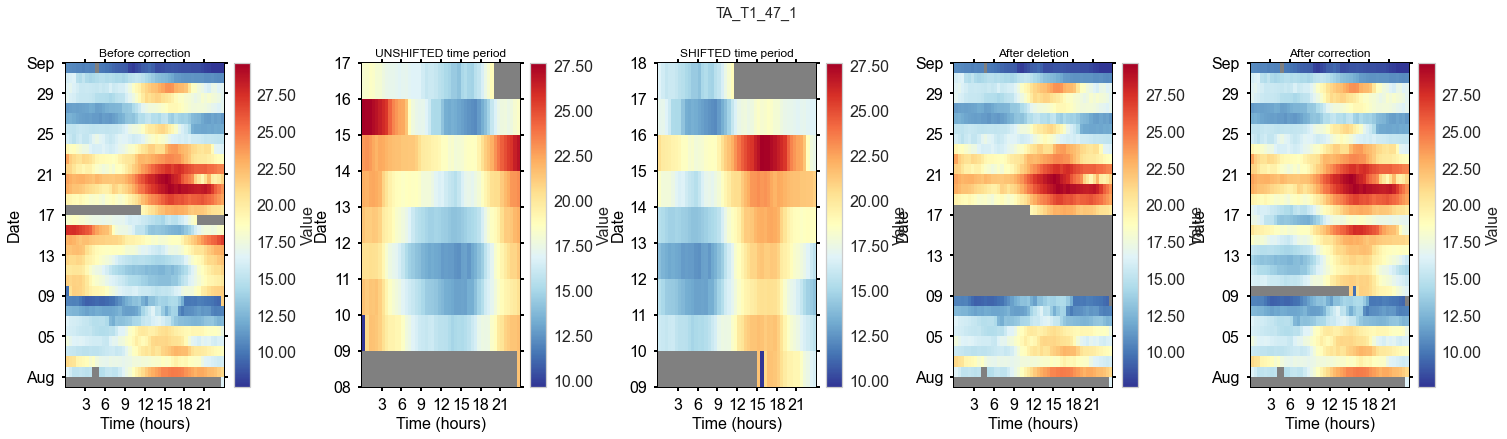

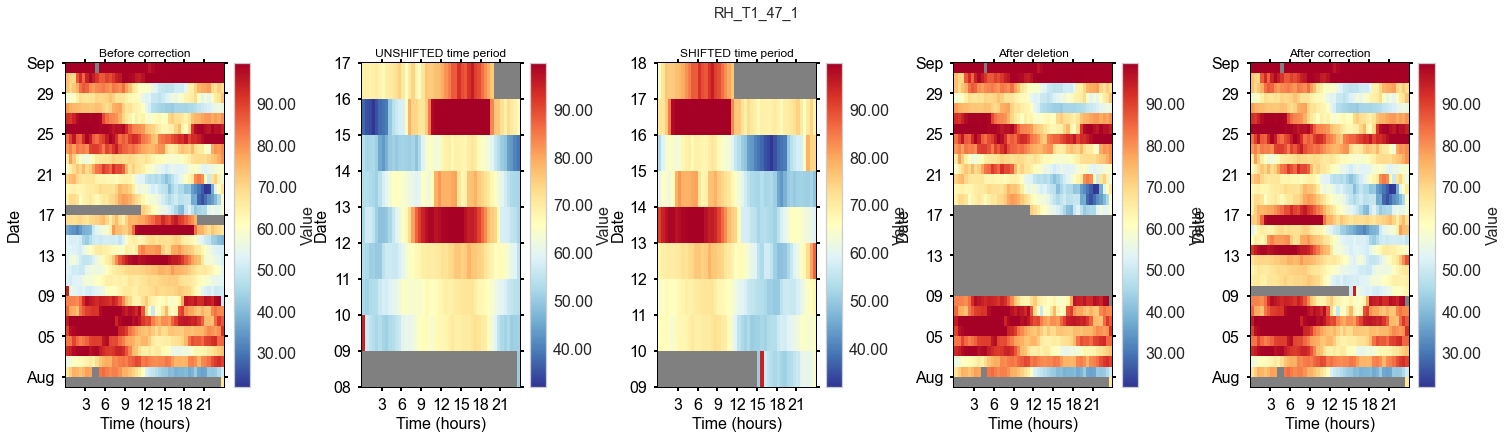

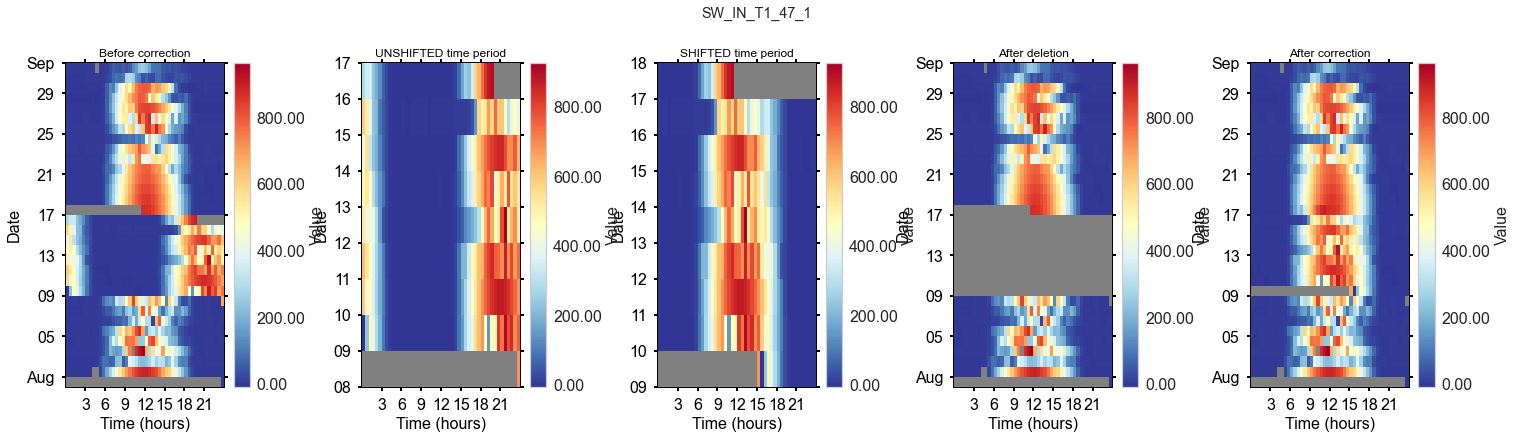

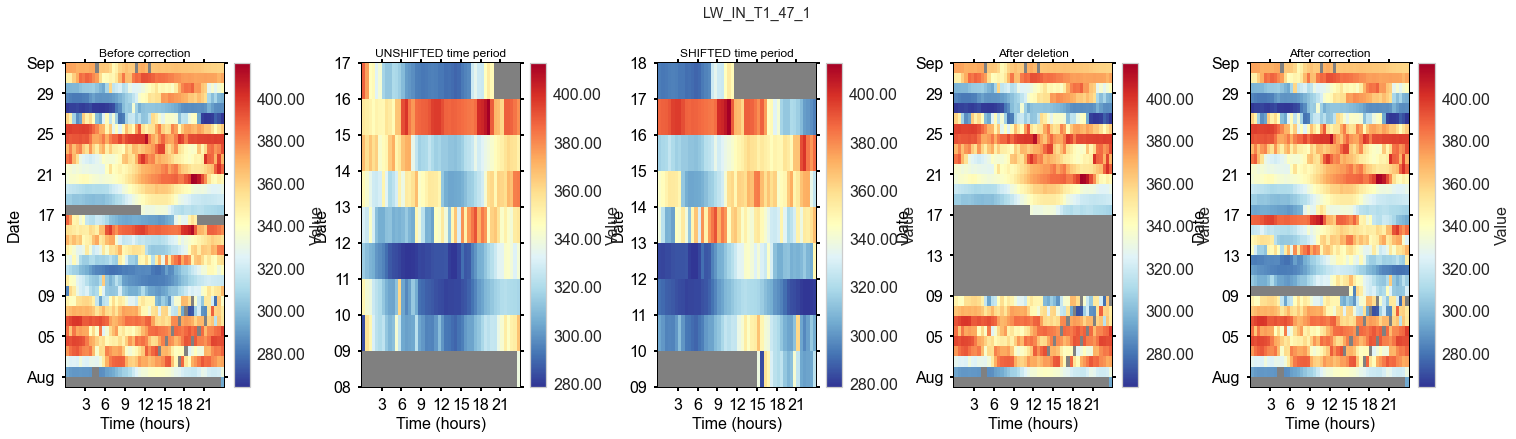

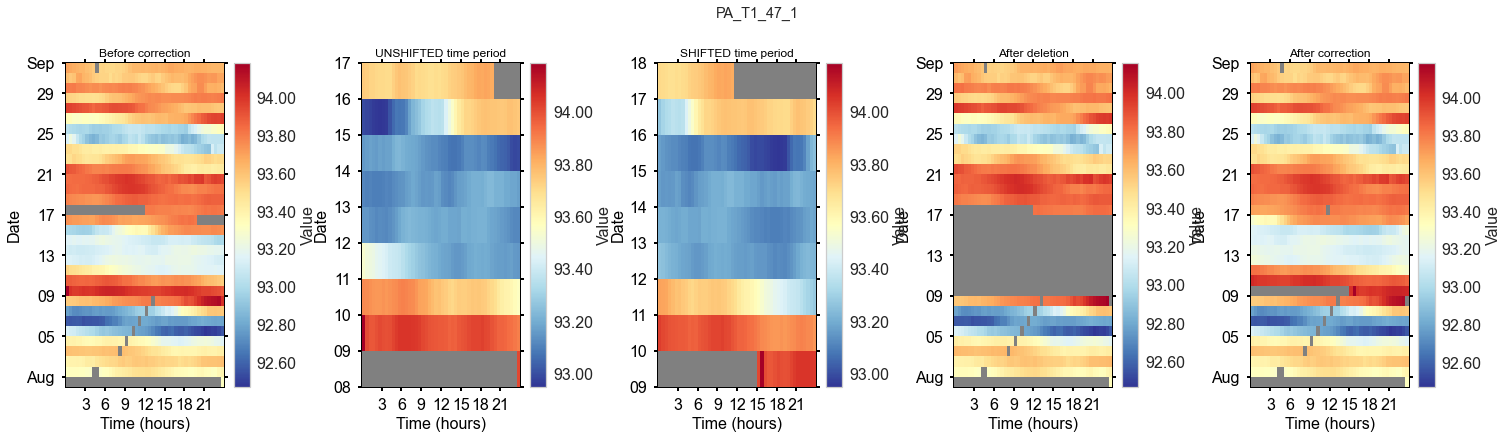

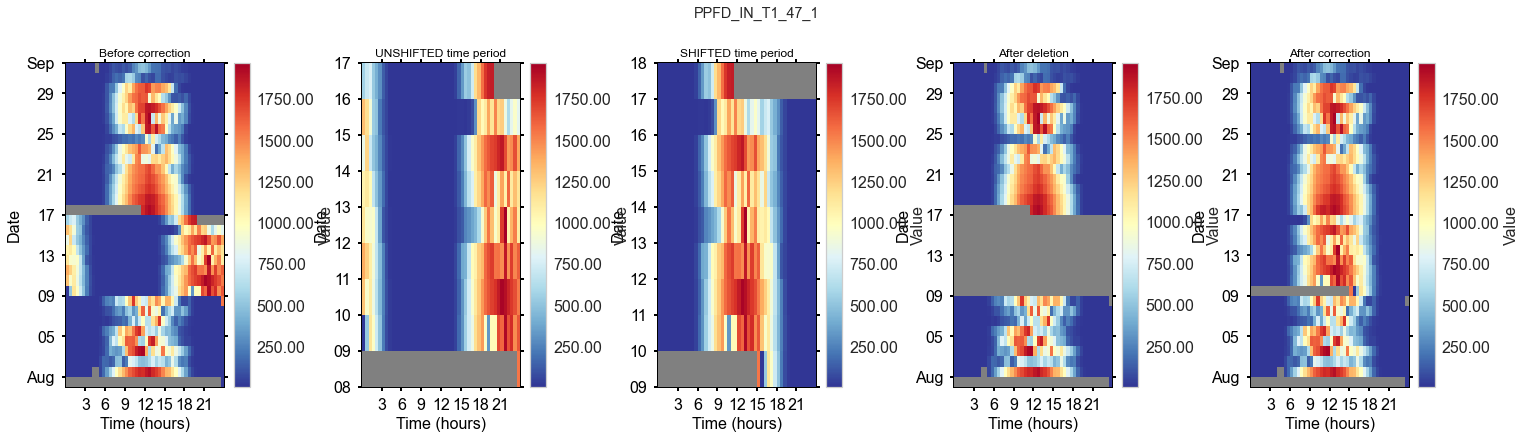

In [11]:
AFFECTED_VARS = ['TA_T1_47_1', 'RH_T1_47_1', 'SW_IN_T1_47_1', 'LW_IN_T1_47_1', 'PA_T1_47_1', 'PPFD_IN_T1_47_1']

for av in AFFECTED_VARS:
    fig = plt.figure(figsize=(24, 6), dpi=72)
    fig.suptitle(f"{av}")
    gs = gridspec.GridSpec(1, 5)  # rows, cols
    gs.update(wspace=0.5, hspace=1, left=.1, right=.9, top=.85, bottom=.1)
    ax_before = fig.add_subplot(gs[0, 0])
    ax_unshifted = fig.add_subplot(gs[0, 1])
    ax_shifted = fig.add_subplot(gs[0, 2])
    ax_after = fig.add_subplot(gs[0, 3])
    ax_corrected = fig.add_subplot(gs[0, 4])
    
    # Show time period around issue, before correction
    # _series = data_simple_mst[av].copy()
    _show_locs = (data_simple_mst.index >= '2012-08-01 00:00') & (data_simple_mst.index <= '2012-09-01 00:00')
    dv.heatmapdatetime(series=data_simple_mst.loc[_show_locs, av], ax=ax_before, title="Before correction").plot()
    
    # Get shifted time period
    _series_corrected = data_simple_mst.loc[_show_locs, av].copy()
    # Identify shifted time period
    ISSUE_START = '2012-08-09 00:00'
    ISSUE_END = '2012-08-17 00:00'
    _shifted_locs = (data_simple_mst.index >= ISSUE_START) & (data_simple_mst.index <= ISSUE_END)
    _series_shifted = data_simple_mst.loc[_shifted_locs, av].copy()
    _series_shifted = _series_shifted.dropna()
    dv.heatmapdatetime(series=_series_shifted, ax=ax_unshifted, title="UNSHIFTED time period").plot()
    
    # Shift SW_IN by 15.5 hours during shifted time period, create corrected time series
    _series_shifted.index = _series_shifted.index + pd.Timedelta(hours=15.5)
    dv.heatmapdatetime(series=_series_shifted, ax=ax_shifted, title="SHIFTED time period").plot()
    
    # Delete data between start of issue and the last timestamp of shifted data
    _overwrite_locs = (data_simple_mst.index >= ISSUE_START) & (data_simple_mst.index <= _series_shifted.index[-1])
    data_simple_mst.loc[_overwrite_locs, av] = np.nan
    dv.heatmapdatetime(series=data_simple_mst.loc[_show_locs, av], ax=ax_after, title="After deletion").plot()
    
    # Fill in corrected values
    data_simple_mst.loc[_overwrite_locs, av] = _series_shifted
    # _series_corrected = _series_corrected.combine_first(_series_shifted)
    dv.heatmapdatetime(series=data_simple_mst.loc[_show_locs, av], ax=ax_corrected, title="After correction").plot()
    
    # print(_series_shifted.index[-1])
    # print(_series_shifted)
    # print(_series_corrected[_overwrite_locs])

## Rename variables for merging

In [12]:
renaming_dict = {
    'LW_IN_T1_47_1': 'LW_IN_T1_47_1',
    'PPFD_IN_T1_47_1': 'PPFD_IN_T1_47_1',
    'RH_T1_47_1': 'RH_T1_47_1',
    'SW_IN_T1_47_1': 'SW_IN_T1_47_1',
    'TA_T1_47_1': 'TA_T1_47_1',
    'PA_T1_47_1': 'PA_T1_47_1'
}
data_simple_mst = data_simple_mst.rename(columns=renaming_dict)
data_simple_mst

,LW_IN_T1_47_1,PA_T1_47_1,PPFD_IN_T1_47_1,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,,,,
2004-09-20 11:00:00,NaN,NaN,1078.000000,81.199997,NaN,13.300000
2004-09-20 11:30:00,NaN,NaN,889.000000,78.199997,NaN,13.390000
2004-09-20 12:00:00,NaN,NaN,1030.000000,76.500000,NaN,13.810000
2004-09-20 12:30:00,NaN,NaN,1292.000000,72.199997,NaN,14.470000
2004-09-20 13:00:00,NaN,NaN,750.000000,73.400002,NaN,13.980000
...,...,...,...,...,...,...
2021-12-31 22:00:00,280.736376,94.122552,2.593284,94.843261,-9.935194,7.933211
2021-12-31 22:30:00,281.142280,94.137379,2.600834,93.992424,-10.250348,8.022416
2021-12-31 23:00:00,280.816904,94.160062,2.574417,95.821067,-9.810373,7.719400


</br>

# Merge data

In [13]:
# Merge data on index
data_simple_merged = pd.concat([data_simple_diive, data_simple_mst], axis=0)
data_simple_merged = data_simple_merged.sort_index()
data_simple_merged

,LW_IN_T1_47_1,PA_T1_47_1,PPFD_IN_T1_47_1,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,,,,
2004-09-20 11:00:00,NaN,NaN,1078.0,81.199997,NaN,13.300000
2004-09-20 11:30:00,NaN,NaN,889.0,78.199997,NaN,13.390000
2004-09-20 12:00:00,NaN,NaN,1030.0,76.500000,NaN,13.810000
2004-09-20 12:30:00,NaN,NaN,1292.0,72.199997,NaN,14.470000
2004-09-20 13:00:00,NaN,NaN,750.0,73.400002,NaN,13.980000
...,...,...,...,...,...,...
2024-12-31 22:00:00,232.595527,94.211806,0.0,87.387340,0.0,-0.504794
2024-12-31 22:30:00,232.609777,94.189013,0.0,87.563567,0.0,-0.296828
2024-12-31 23:00:00,232.345020,94.169525,0.0,89.921251,0.0,-0.392922


</br>

## Set start date to 1 Jan 2004

In [14]:
# # Define the date for the new row
# start_date = pd.to_datetime('2004-01-01 00:30:00')

# # Create a new DataFrame for this single row
# # Initialize with NaN values for all columns that exist in the original DataFrame
# new_row_data = {col: [np.nan] for col in data_simple_merged.columns}
# new_row_df = pd.DataFrame(new_row_data, index=[start_date])

# # Concatenate the new row DataFrame with the original DataFrame
# # Use sort_index() to ensure the combined DataFrame is in chronological order
# data_simple_merged = pd.concat([new_row_df, data_simple_merged]).sort_index()
# data_simple_merged.index.name = "TIMESTAMP_END"
# data_simple_merged

</br>

## Sanitize timestamp

In [15]:
data_simple_merged = TimestampSanitizer(data=data_simple_merged, output_middle_timestamp=False).get()
data_simple_merged

,LW_IN_T1_47_1,PA_T1_47_1,PPFD_IN_T1_47_1,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,,,,
2004-09-20 11:00:00,NaN,NaN,1078.0,81.199997,NaN,13.300000
2004-09-20 11:30:00,NaN,NaN,889.0,78.199997,NaN,13.390000
2004-09-20 12:00:00,NaN,NaN,1030.0,76.500000,NaN,13.810000
2004-09-20 12:30:00,NaN,NaN,1292.0,72.199997,NaN,14.470000
2004-09-20 13:00:00,NaN,NaN,750.0,73.400002,NaN,13.980000
...,...,...,...,...,...,...
2024-12-31 22:00:00,232.595527,94.211806,0.0,87.387340,0.0,-0.504794
2024-12-31 22:30:00,232.609777,94.189013,0.0,87.563567,0.0,-0.296828
2024-12-31 23:00:00,232.345020,94.169525,0.0,89.921251,0.0,-0.392922


</br>

## Correction: Remove zero offset < 0 from `SW_IN`

[remove_radiation_zero_offset]  running remove_radiation_zero_offset ...


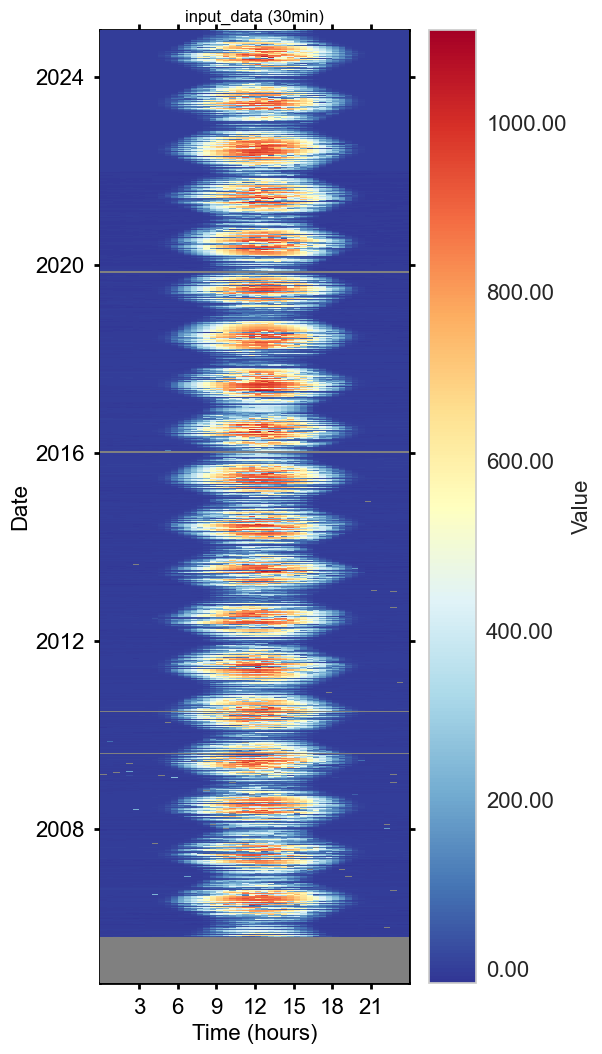

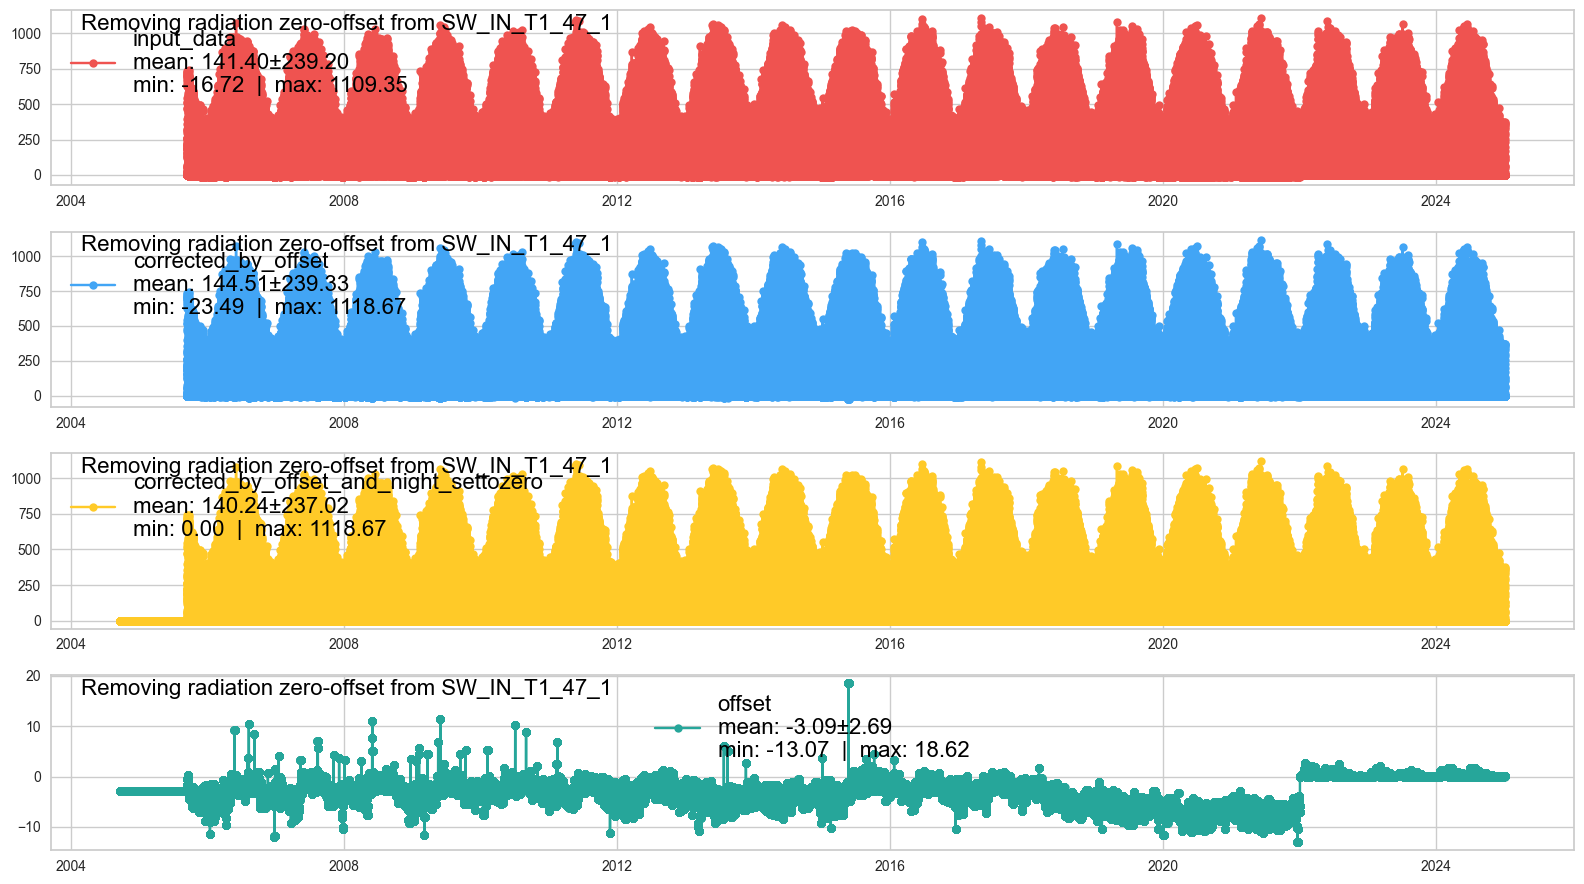

In [16]:
_swin = data_simple_merged['SW_IN_T1_47_1'].copy()
_swin_corrected = remove_radiation_zero_offset(series=_swin, lat=SITE_LAT, lon=SITE_LON, utc_offset=1, showplot=True)
data_simple_merged['SW_IN_T1_47_1'] = np.nan
data_simple_merged['SW_IN_T1_47_1'] = _swin_corrected

</br>

## Correction: Remove zero offset < 0 from `PPFD_IN`

[remove_radiation_zero_offset]  running remove_radiation_zero_offset ...


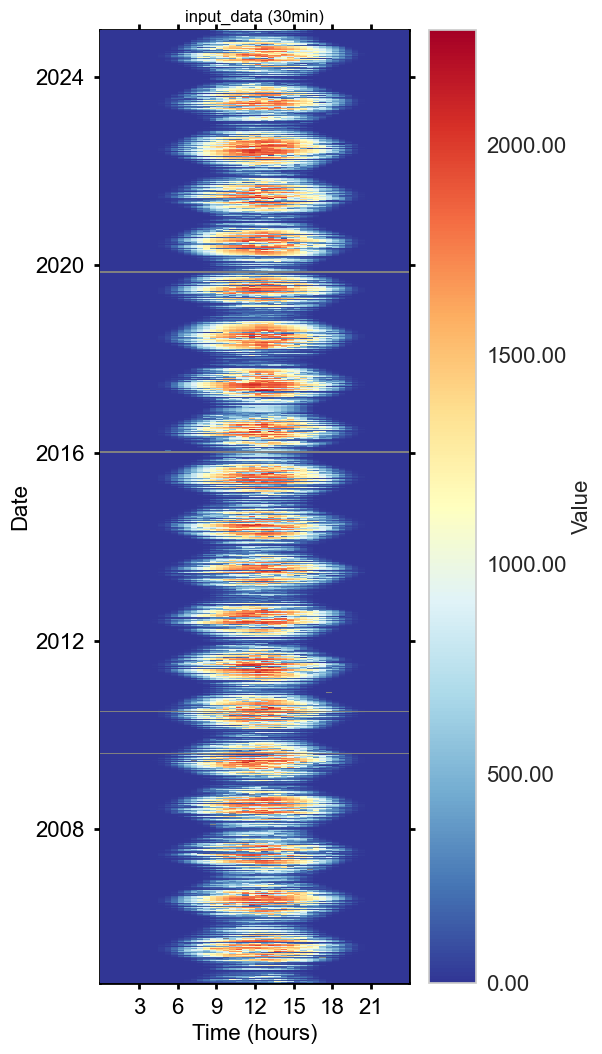

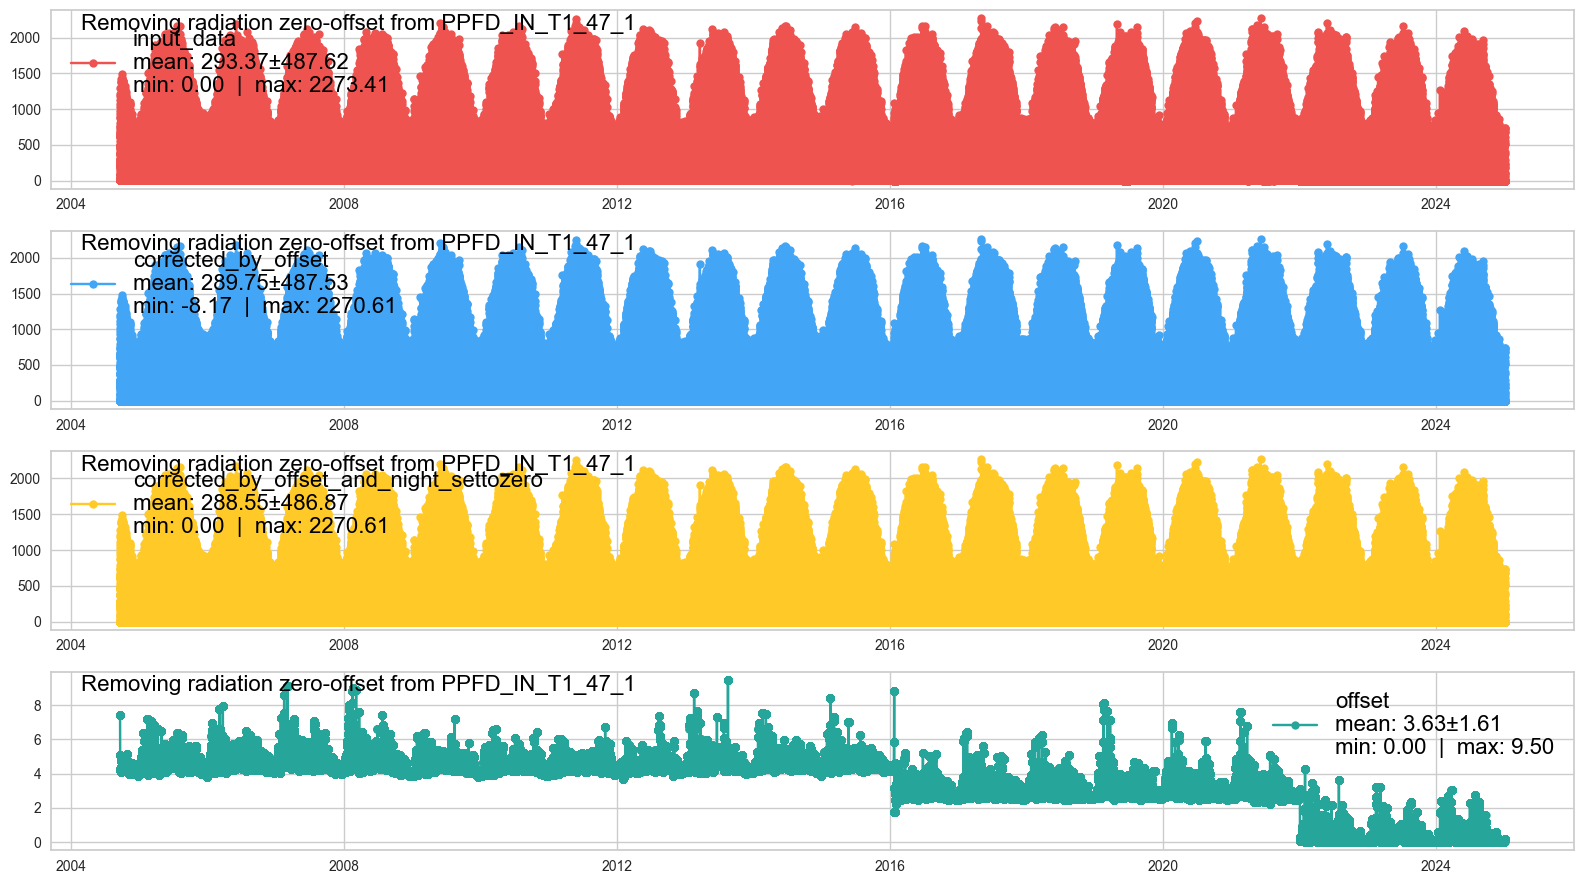

In [17]:
_ppfdin = data_simple_merged['PPFD_IN_T1_47_1'].copy()
_ppfdin_corrected = remove_radiation_zero_offset(series=_ppfdin, lat=SITE_LAT, lon=SITE_LON, utc_offset=1, showplot=True)
data_simple_merged['PPFD_IN_T1_47_1'] = np.nan
data_simple_merged['PPFD_IN_T1_47_1'] = _ppfdin_corrected

</br>

## Correction: Remove offset >100% from `RH`

[remove_relativehumidity_offset]  running remove_relativehumidity_offset ...


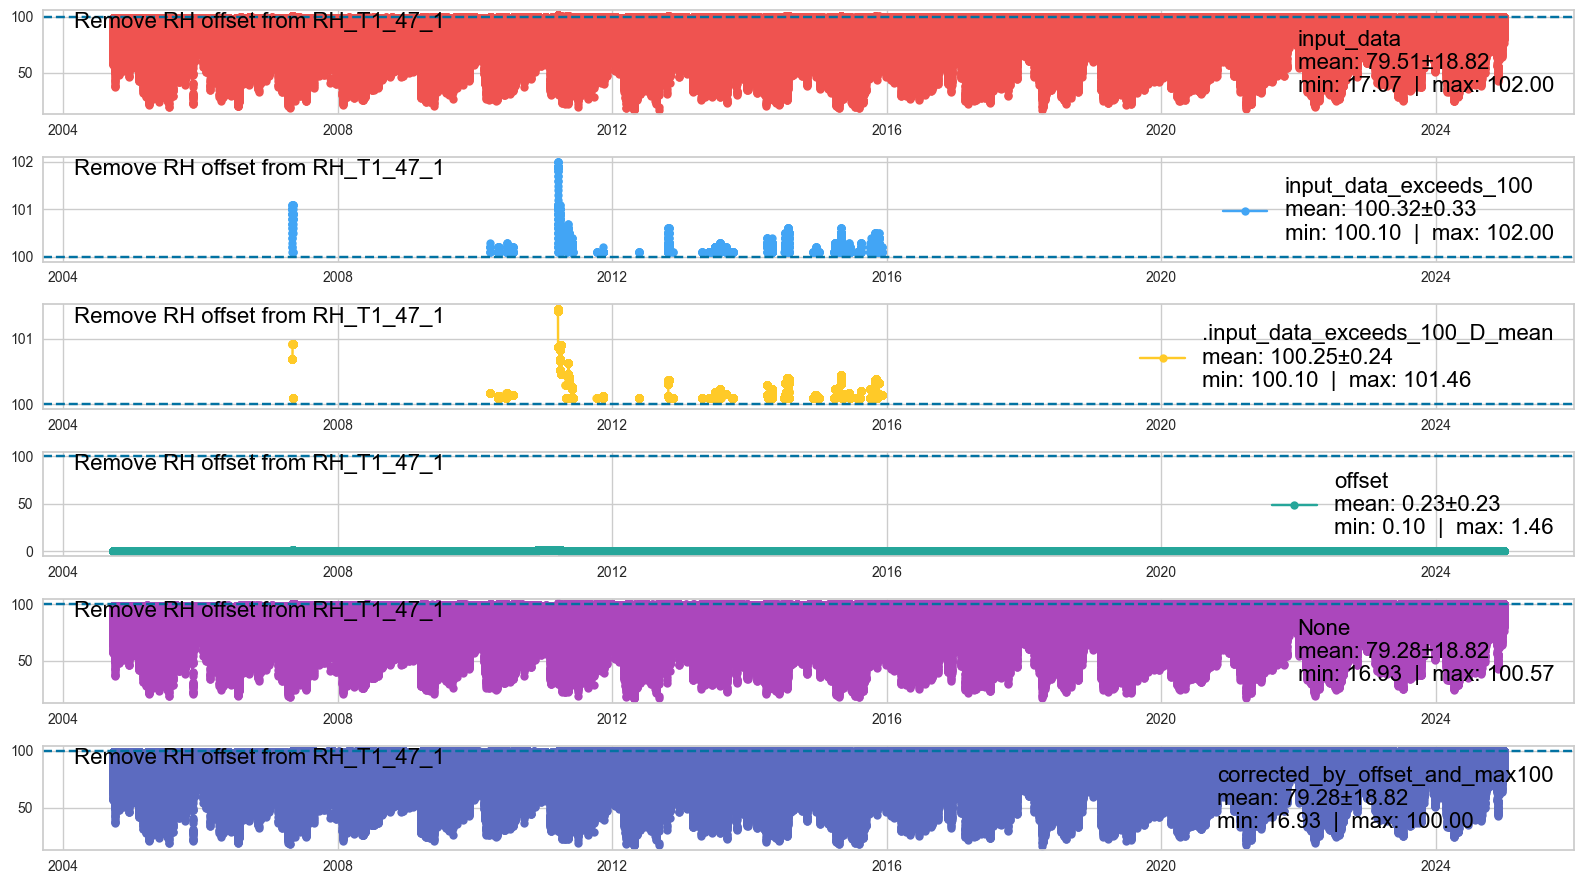

In [18]:
_rh = data_simple_merged['RH_T1_47_1'].copy()
_rh_corrected = remove_relativehumidity_offset(series=_rh, showplot=True)
data_simple_merged['RH_T1_47_1'] = np.nan
data_simple_merged['RH_T1_47_1'] = _rh_corrected

</br>

# Plot

In [19]:
_plot_df = data_simple_merged[FIELDS].copy()
_plot_df = _plot_df.replace(-9999, np.nan)

## Time series plot

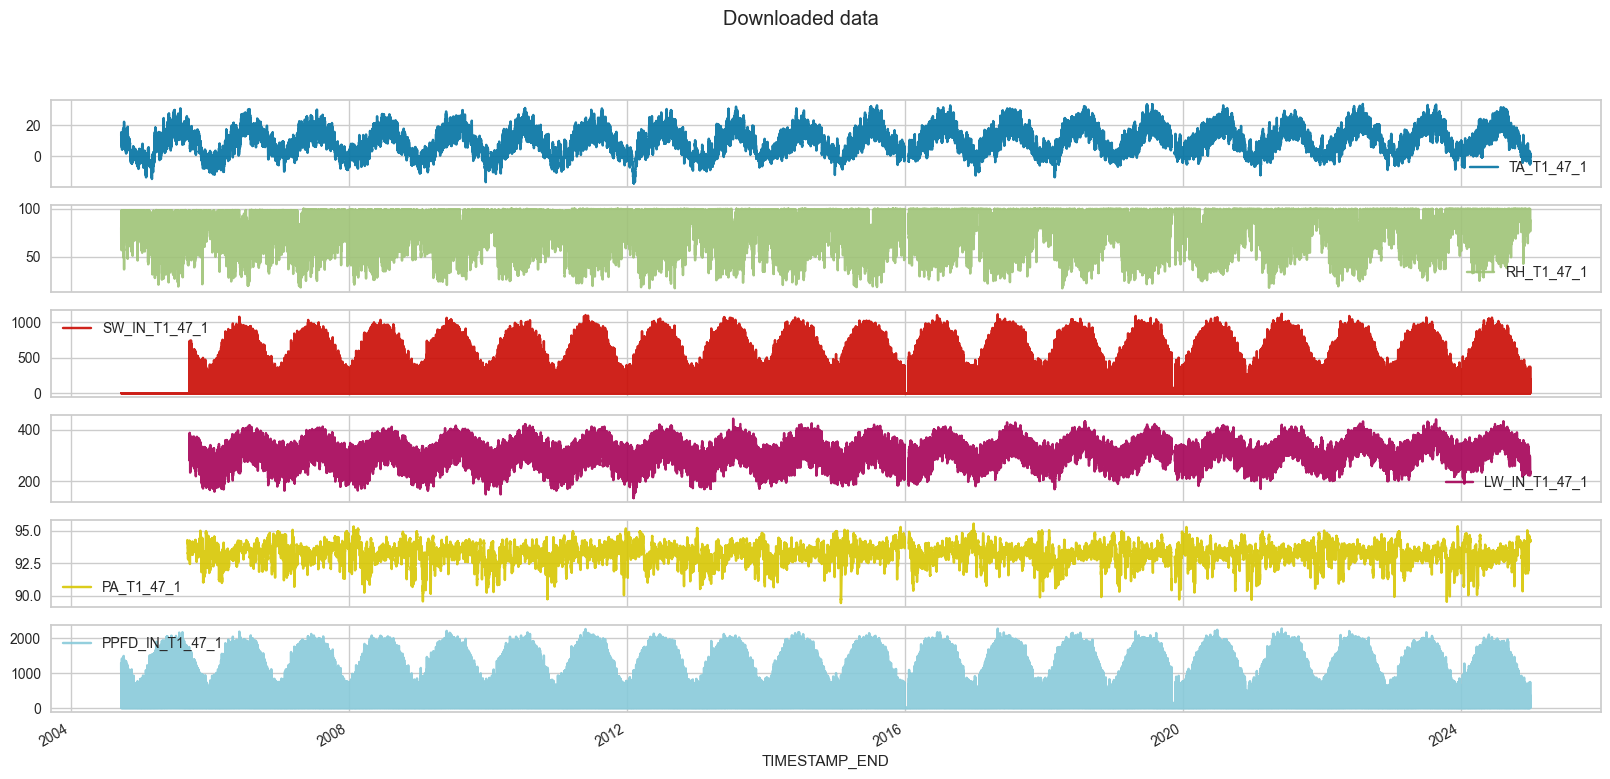

In [20]:
_plot_df.plot(subplots=True, figsize=(20, 9), title="Downloaded data", alpha=.9, x_compat=True);

## Heatmaps

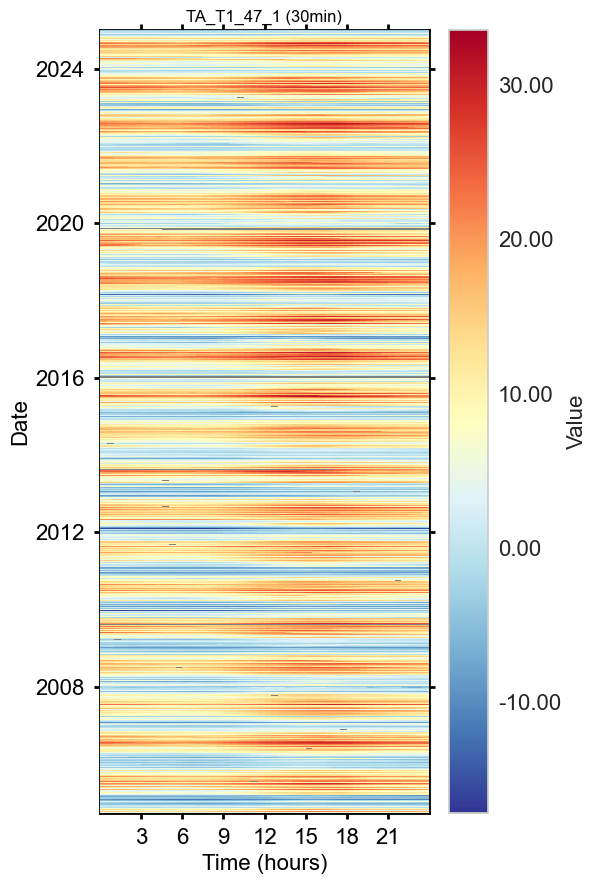

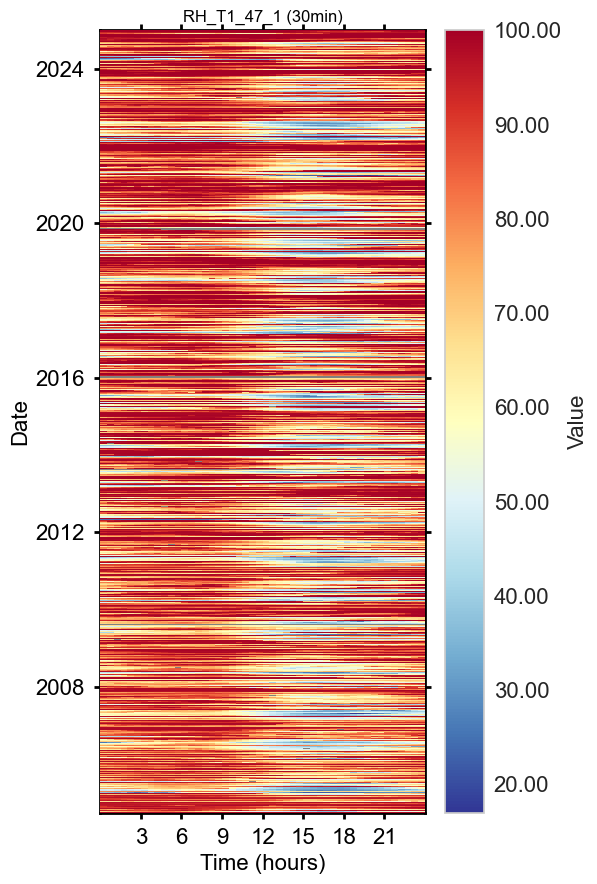

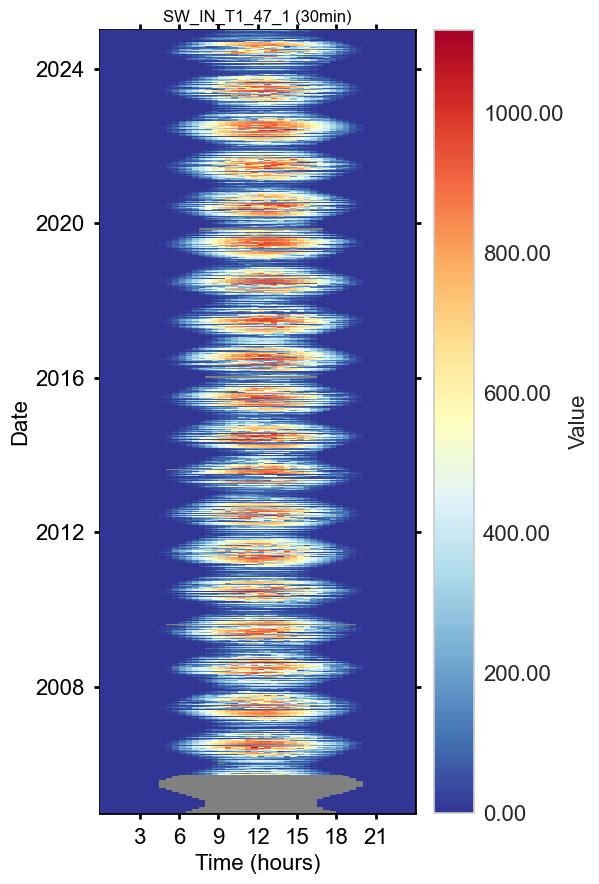

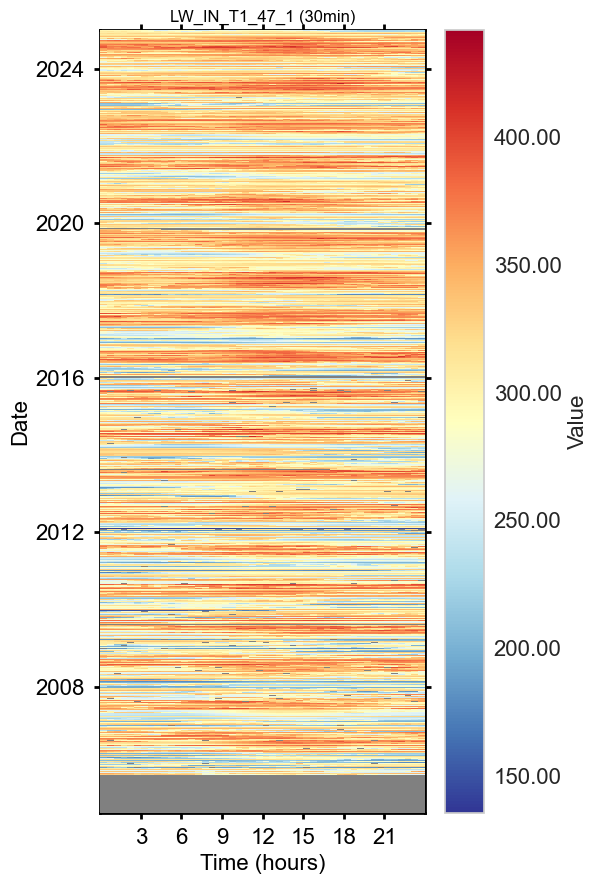

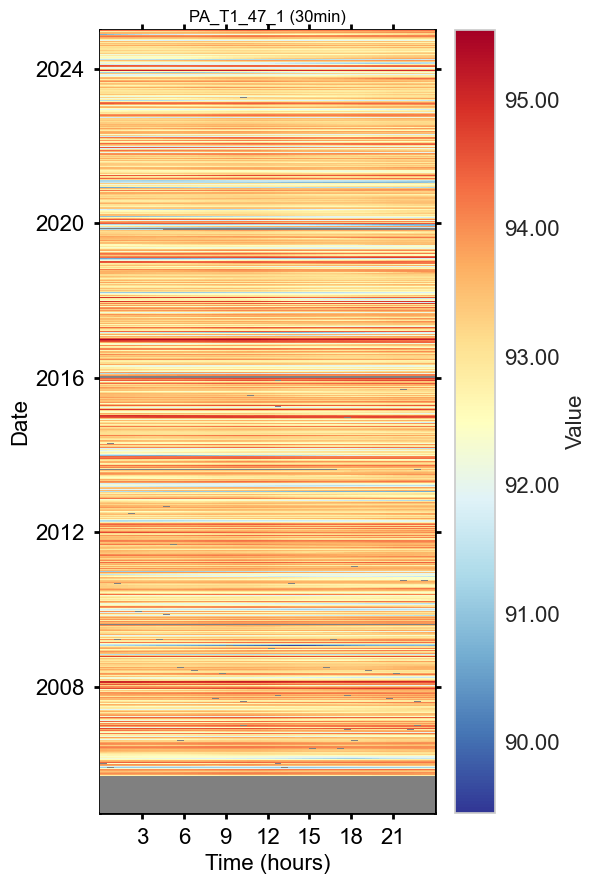

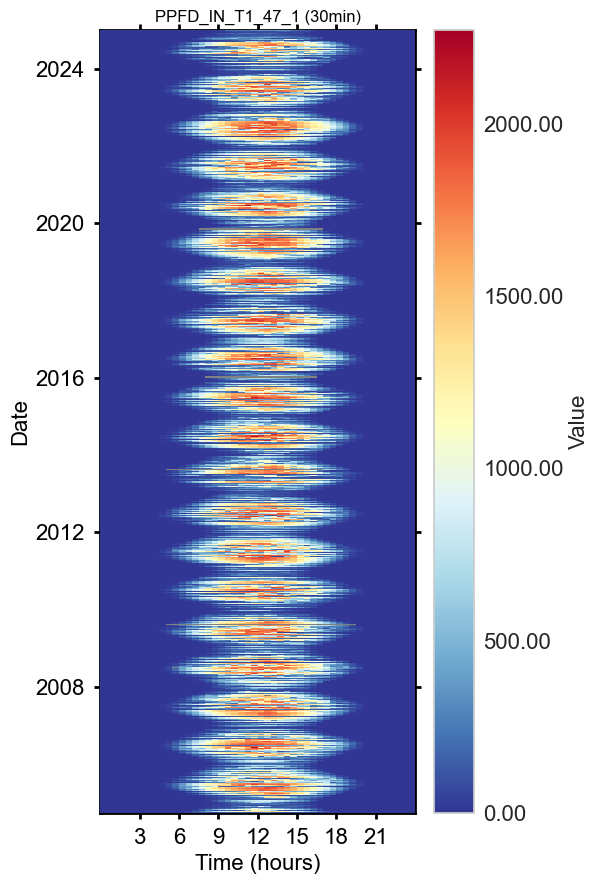

In [21]:
for col in _plot_df.columns:    
    series = _plot_df[col]
    series.name = col
    HeatmapDateTime(series, figsize=(6,9)).show()    

</br>

# Save to file

In [22]:
OUTNAME = "12.1_METEO_NOT-GAPFILLED_2004-2024"
OUTPATH = r""
filepath = save_parquet(filename=OUTNAME, data=data_simple_merged, outpath=OUTPATH)
data_simple_merged.to_csv(Path(OUTPATH) / f"{OUTNAME}.csv")

Saved file 12.1_METEO_NOT-GAPFILLED_2004-2024.parquet (0.139 seconds).


</br>

# End of notebook.

In [23]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2025-06-11 16:10:18


</br>